## Daily Updated Exchange Rates (2015-now)

**Description:**

This will involve an analysis and Long Short-Term Memory (LSTM) prediction model on the exchange rate of Euros to USD currency. The dataset (exchanges.csv) contains a collection of daily records capturing the top 56 currencies from 2015 to the present day. The dataset is based on the reference currency euros ("EUR").

In [1]:
# import libraries
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.layers import Dense
from keras.models import Sequential
from pandas.plotting import autocorrelation_plot, lag_plot
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
# Import dataset 
df = pd.read_csv("exchanges.csv")
# Set date as index
df = df.set_index(['date'])

In [3]:
# Visualize the shape of the dataset
df.shape

(3045, 53)

In [4]:
# Find missing values for each column
missing_values = df.isna().sum().sort_values(ascending=False)
missing_values[:5]

HRK    213
ARS      0
SGD      0
NPR      0
NZD      0
dtype: int64

HRK has 213 missing values as this currency was not added into the report until the 214th day.

In [30]:
# Descriptive Statistics
df['USD'].describe()

count    3045.000000
mean        1.124994
std         0.053875
min         0.962391
25%         1.089999
50%         1.121944
75%         1.166537
max         1.248973
Name: USD, dtype: float64

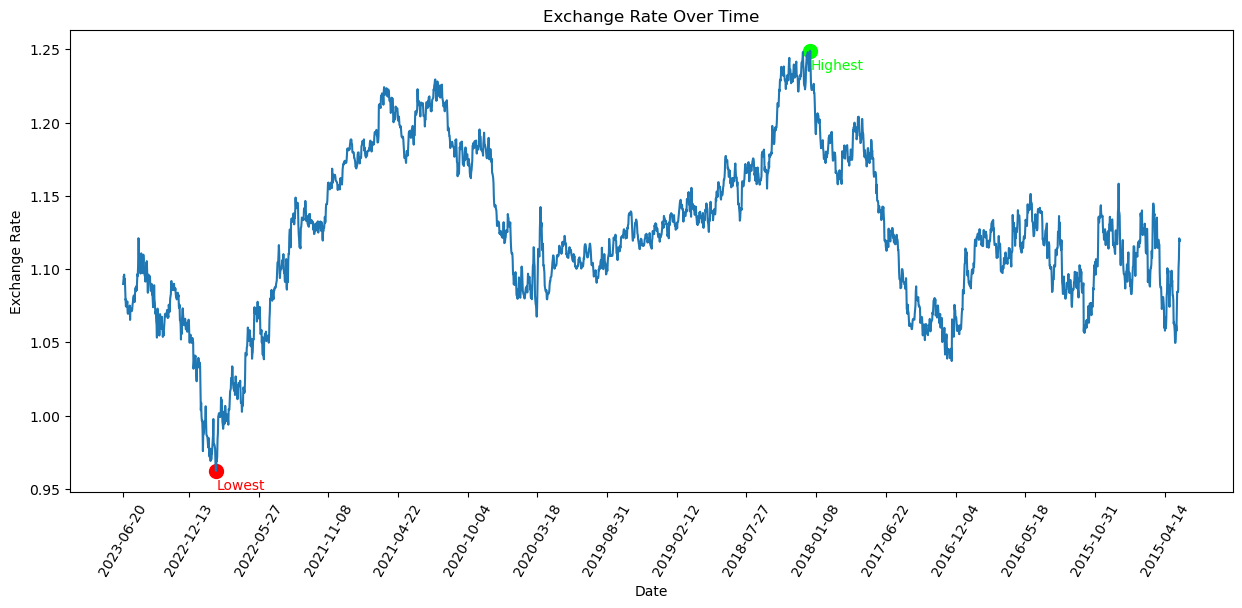

Date of the Lowest Exchange Rate: 2022-09-26
Date of the Highest Exchange Rate: 2018-01-25


In [85]:
# Plot df['USD']
plt.figure(figsize=(15, 6))
plt.plot(df['USD'], label='Exchange Rate')

# Find the row with the minimum value
min_row = df.loc[df['USD'].idxmin()]

# Access the minimum date
min_date = min_row.name
# Get the minimum exchange rate
min_value = min_row['USD']

# Find the row with the maximum value
max_row = df.loc[df['USD'].idxmax()]
# Access the maximum date and value
max_date = max_row.name
max_value = max_row['USD']

# Add marker or annotation for the minimum value
plt.scatter(min_date, min_value, color='red', marker='o', s=100)
plt.scatter(max_date, max_value, color='#00FF00', marker='o', s=100)

# You can use plt.annotate() to add text annotation instead:
plt.annotate('Lowest', xy=(min_date, min_value), xytext=(min_date, min_value - 0.013), color='red')
plt.annotate('Highest', xy=(max_date, max_value), xytext=(max_date, max_value - 0.013), color='#00FF00')
# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Exchange Rate Over Time')
plt.xticks(df.index[::200])
plt.xticks(rotation=60)
plt.xticks(fontsize=10)

# Show the plot
plt.show()

print("Date of the Lowest Exchange Rate:", min_date)
print("Date of the Highest Exchange Rate:", max_date)

Identifying the peaks of the exchange rates can allow researchers to analyze valuable insights on the factors on the date for the fluctuations. 

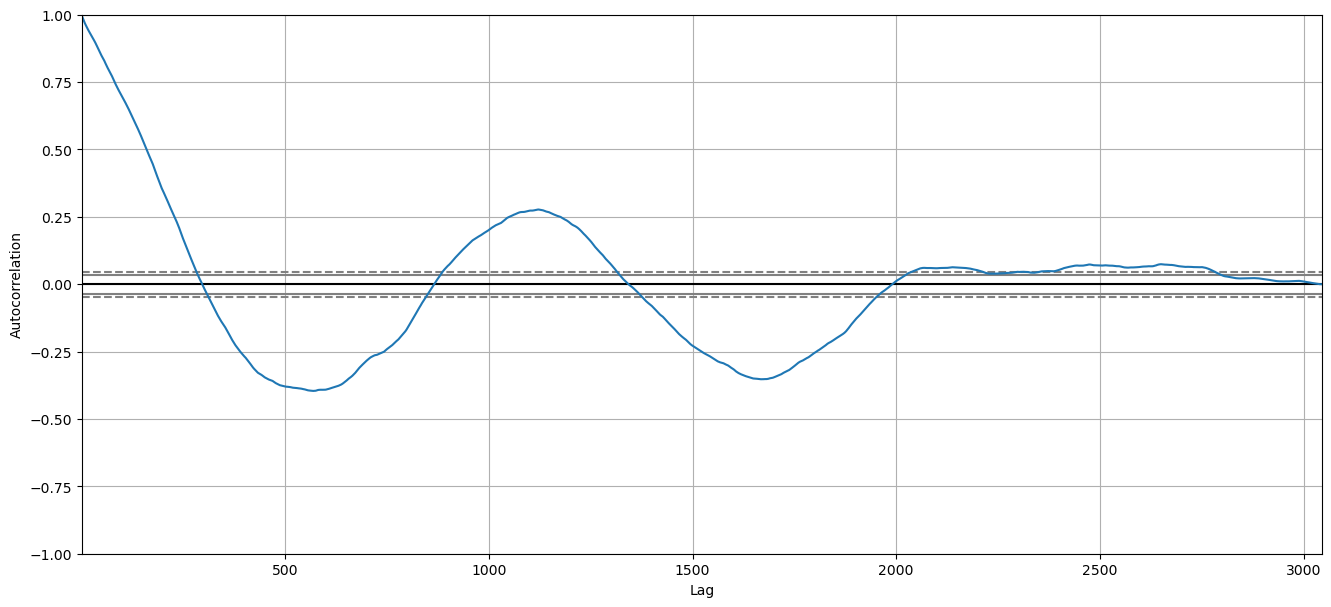

In [21]:
# Autocorrelation of dataset
plt.figure(figsize=(16, 7)) 
autocorrelation_plot(df["USD"])
plt.show()

This autocorrelation graph shows the relationship a value has with its lags (previous values). A correlation coefficient closer to 1 or -1 represents a strong correlation. 

In [5]:
# Stationary Test Function
def stationarity_test(data):
    dftest = adfuller(data, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Numberof Observations Used'])
    Rolling_mean = data.rolling(window=12).mean()
    Rolling_std = data.rolling(window=12).std()
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    plt.figure(figsize=(20, 7))
    plt.plot(Rolling_mean, color='red', label='Rolling Mean')
    plt.plot(Rolling_std, color='black', label='Rolling Std')
    n = 200  # Show every 50th tick
    plt.xticks(df.index[::n])
    plt.xticks(rotation=60)
    plt.xticks(fontsize=12)
    plt.legend(fontsize=20)
    plt.plot(data.index, data)
    plt.show()

Test Statistic                  -2.470670
p-value                          0.122775
#Lags Used                       0.000000
Numberof Observations Used    3044.000000
Critical Value (1%)             -3.432500
Critical Value (5%)             -2.862490
Critical Value (10%)            -2.567276
dtype: float64


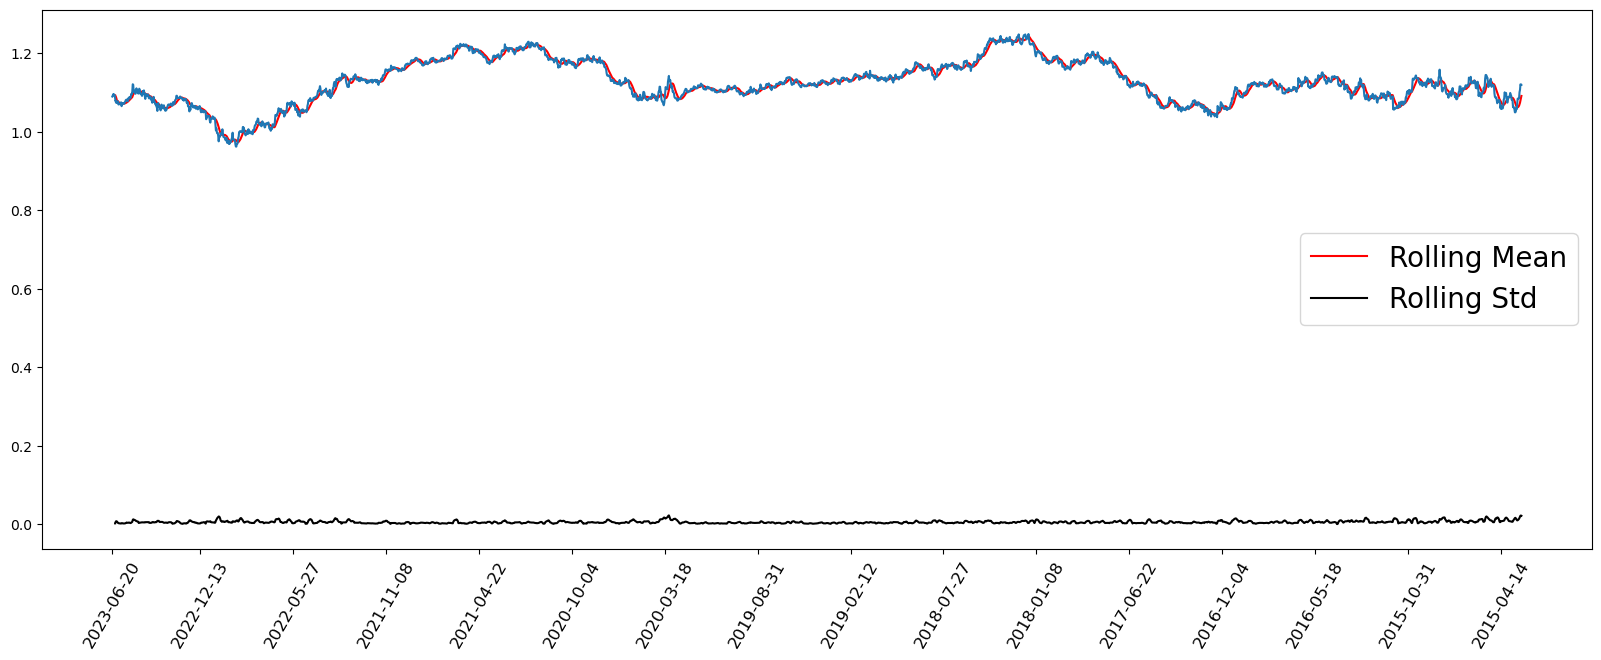

In [6]:
stationarity_test(df['USD'])

The exchange rate between EUR and USD is not stationary as there is insufficient evidence to reject the null hypothesis of non-stationarity, therefore, the exchange ratio follows a non-stationary process. Predicting the exchange ratio is always challenging even with pristine techniques such as LSTM because macroeconomic indicators, geopolitical events, market sentiments, interest rates, and investor behavior influence the exchange ratio.

### Feature Selection

In [8]:
# Convert date strings to datetime objects
df_datetime = [datetime.datetime.strptime(date_str, '%Y-%m-%d') for date_str in df.index]

# Convert datetime objects to numerical values (e.g., timestamp)
df_numeric = [date_obj.timestamp() for date_obj in df_datetime]
df_numeric = np.array(df_numeric)

In [9]:
# Split dataframe into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(df_numeric, df['USD'], test_size=0.3, random_state=42)

In [11]:
# Convert the training and testing data into numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Reshape the input data for LSTM
X_train = X_train.reshape(X_train.shape[0], 1, 1)
X_test = X_test.reshape(X_test.shape[0], 1, 1)

# Create the LSTM model
model = Sequential()
model.add(LSTM(units=64, input_shape=(1, 1)))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

Metal device set to: Apple M1 Pro


In [12]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
67/67 [==============================] - 2s 9ms/step - loss: 0.3956
Epoch 2/10
67/67 [==============================] - 1s 8ms/step - loss: 0.0183
Epoch 3/10
67/67 [==============================] - 1s 7ms/step - loss: 0.0029
Epoch 4/10
67/67 [==============================] - 1s 8ms/step - loss: 0.0028
Epoch 5/10
67/67 [==============================] - 1s 8ms/step - loss: 0.0028
Epoch 6/10
67/67 [==============================] - 1s 8ms/step - loss: 0.0028
Epoch 7/10
67/67 [==============================] - 0s 7ms/step - loss: 0.0028
Epoch 8/10
67/67 [==============================] - 0s 7ms/step - loss: 0.0028
Epoch 9/10
67/67 [==============================] - 0s 7ms/step - loss: 0.0028
Epoch 10/10
67/67 [==============================] - 1s 8ms/step - loss: 0.0028


In [13]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Mean Squared Error (MSE):", loss)

29/29 [==============================] - 0s 4ms/step - loss: 0.0031
Mean Squared Error (MSE): 0.0031199653167277575


In [14]:
# Make predictions
predictions = model.predict(X_test)

29/29 [==============================] - 0s 3ms/step


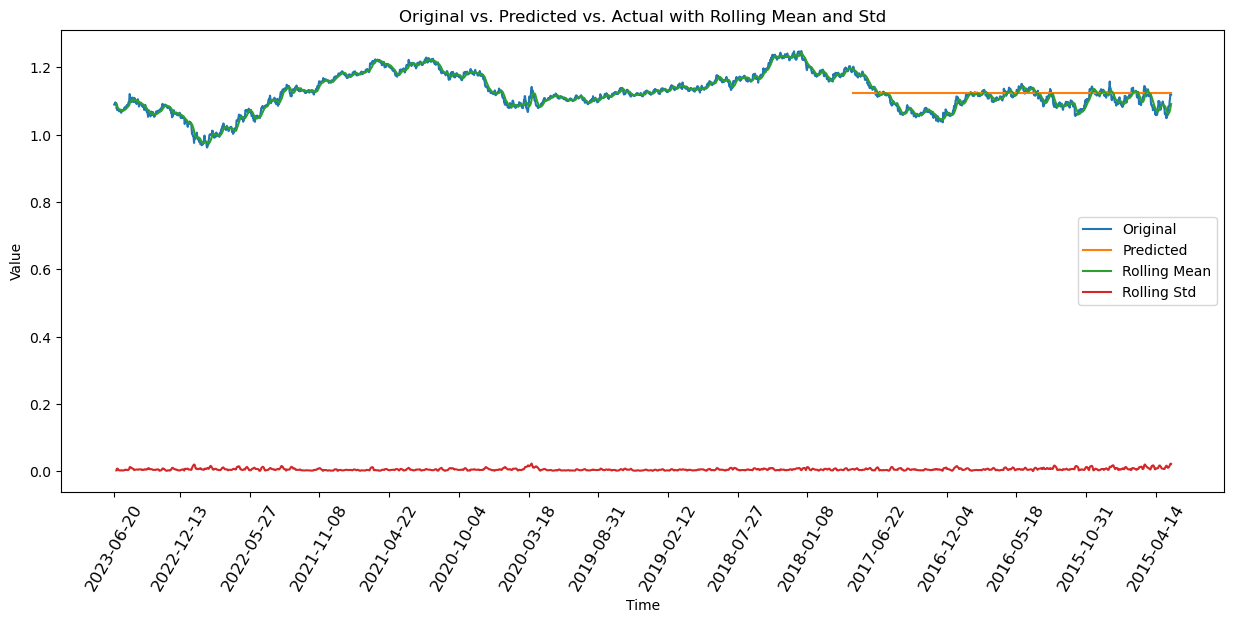

In [88]:
# Calculate rolling mean and standard deviation
rolling_mean = df['USD'].rolling(window=12).mean()
rolling_std = df['USD'].rolling(window=12).std()
plt.figure(figsize=(15, 6))
# Plot all of the data
plt.plot(df['USD'], label='Original')
# plt.plot(df.index[-len(y_test):], y_test, label='Actual')
plt.plot(df.index[-len(predictions):], predictions, label='Predicted')
plt.plot(df.index, rolling_mean, label='Rolling Mean')
plt.plot(df.index, rolling_std, label='Rolling Std')

# Set plot labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original vs. Predicted vs. Actual with Rolling Mean and Std')
n = 200
plt.xticks(df.index[::n])
plt.xticks(rotation=60)
plt.xticks(fontsize=12)
# Add legend
plt.legend()

# Show the plot
plt.show()